In [20]:
import torch
import torchvision.models as models
from torchvision import transforms
import torch
import json
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn

from PIL import Image
import UNet_utils
import other_utils
import ddpm_utils
import clip
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128*4
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
IMG_CH = 3
IMG_SIZE = 32
ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)

# Bước 1: Tải trọng số đã lưu vào mô hình
state_dict = torch.load(r'C:\Users\QUIN\Desktop\PPNCKH\model_flowers.pth')

# Nếu mô hình được huấn luyện với DataParallel, cần phải xóa tiền tố 'module.'
new_state_dict = {}
for k, v in state_dict.items():
    new_state_dict[k.replace('module.', '')] = v

# Tải trọng số đã sửa vào mô hình
model.load_state_dict(new_state_dict)
model = model.to(device)
# Bước 2: Chuyển mô hình sang chế độ đánh giá (evaluation mode)
model.eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model_hf = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)


torch.Size([1, 512])
torch.Size([1, 20, 512])


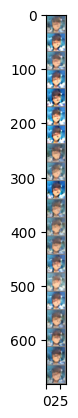

In [29]:
def clip_encode(text, processor, device): 
    inputs = processor(
        text=text, 
        return_tensors="pt", 
        padding="max_length",
        truncation=True, 
        max_length=20, 
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = clip_model_hf.text_model(**inputs)

    return outputs.last_hidden_state * inputs["attention_mask"].unsqueeze(-1) , outputs.pooler_output  # (B, 512)
# Tạo chức năng để sinh hình ảnh từ văn bản
def sample_flowers(text_list):
    # text_tokens = clip.tokenize(text_list).to(device)
    # c = clip_model.encode_text(text_tokens).float()
    c1, c = clip_encode(text_list, processor, device)
    print(c.shape)
    print(c1.shape)
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c.float(), c1.float(), device, list(torch.empty(20).uniform_(0.0, 1.0))
)
    return x_gen, x_gen_store

# Thí dụ với một danh sách văn bản
text_list = [

    'a man in a blue shirt and headband and a black shirt'
  

]

# Sinh hình ảnh
x_gen, x_gen_store = sample_flowers(text_list)

# Hiển thị hình ảnh sinh ra
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid])
